Building the dataset of numerical data

In [ ]:
#### STOP - ONLY if needed
# Allows printing full text
import pandas as pd
pd.set_option('display.max_colwidth', None)


In [ ]:
### PUT MAIN HERE ###

In [8]:
# Machine Learning Challenge
# Course: Machine Learning (880083-M-6)
# Group 58
 
##########################################
#             Import packages            #
##########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import yake  #NOTE: with Anaconda: conda install -c conda-forge yake

##########################################
#      Import self-made functions        #
##########################################
from CODE.data_preprocessing.split_val import split_val
from CODE.data_preprocessing.find_outliers_tukey import find_outliers_tukey

#feature based on the title of the paper
from CODE.features.length_title import length_title

# features based on 'field_of_study' column 
from CODE.features.field_variety import field_variety         
from CODE.features.field_popularity import field_popularity
from CODE.features.field_citations_avarage import field_citations_avarage 

# features based on the topics of the paper
from CODE.features.topic_citations_avarage import topic_citations_avarage
from CODE.features.topic_variety import topics_variety
from CODE.features.topic_popularity import topic_popularity
from CODE.features.topic_citations_avarage import topic_citations_avarage

# features based on the abstract of the paper
from CODE.features.keywords import best_keywords

# features based on the venue of the paper
from CODE.features.venue_popularity import venue_popularity
from CODE.features.venue_citations import venues_citations

from CODE.features.age import age
from CODE.features.abst_words import abst_words

# features based on the authors of the paper
from CODE.features.author_h_index import author_h_index
from CODE.features.paper_h_index import paper_h_index
from CODE.features.team_size import team_size
from CODE.features.author_database import author_database


##########################################
#              Load datasets             #
##########################################
# Main datasets
data = pd.read_json('DATA/train.json')      # Training set
test = pd.read_json('DATA/test.json')       # Test set

# Author-centric datasets
#   These datasets were made using our self-made functions 'citations_per_author' (for the author_citation_dic)
#   These functions took a long time to make (ballpark ~10 minutes on a laptop in 'silent mode'), so instead we 
#   decided to run this function once, save the data, and reload the datasets instead of running the function again. 
import pickle
with open('my_dataset1.pickle', 'rb') as dataset:
    author_citation_dic = pickle.load(dataset)
with open('my_dataset2.pickle', 'rb') as dataset2:
    author_db = pickle.load(dataset2)


##########################################
#        Missing values handling         #
##########################################

# Missing values for feature 'fields_of_study'
data.loc[data['fields_of_study'].isnull(), 'fields_of_study'] = ""

# Missing values for feature 'title'
data.loc[data['title'].isnull(), 'title'] = ""

# Missing values for feature 'abstract'
data.loc[data['abstract'].isnull(), 'abstract'] = ""
    
# Missing values for features 'authors'
data.loc[data['authors'].isnull(), 'authors'] = ""

# Missing values for feature 'venue'
data.loc[data['venue'].isnull(), 'venue'] = ""
    
# Missing values for feature 'year'
# data.loc[data['fields_of_study'].isnull(), 'fields_of_study'] = mean(year) 
        #   Take mean by venue instead
        #       If venue not known, take something else?

# Missing values for feature 'references'
data.loc[data['references'].isnull(), 'references'] = ""

# Missing values for feature 'topics'
data.loc[data['topics'].isnull(), 'topics'] = ""

# Missing values for feature 'is_open_access'
#data.loc[data['is_open_access'].isnull(), 'is_open_access'] = "" 
        #   Take most frequent occurrence for venue
        #       If venue not known, do something else?
    
##########################################
#       Create basic numeric df          #
##########################################
end = len(data)
num_X = data.loc[ 0:end+1 , ('doi', 'citations', 'year', 'references') ]  ##REMOVE DOI


##########################################
#            Feature creation            #
##########################################
"""
FEATURE DATAFRAME: num_X

ALL: After writing a funtion to create a feature, please incorporate your new feature as a column on the dataframe below.
This is the dataframe we will use to train the models.

DO NOT change the order in this section if at all possible
"""
num_X['title_length'] = length_title(data)      # returns a numbered series
num_X['field_variety'] = field_variety(data)    # returns a numbered series 
num_X['field_popularity'] = field_popularity(data) # returns a numbered series
#num_X['field_citations_avarage'] = field_citations_avarage(data) # returns a numbered series
num_X['team_sz'] = team_size(data)           # returns a numbered series
num_X['topic_var'] = topics_variety(data)    # returns a numbered series
num_X['topic_popularity'] = topic_popularity(data) # returns a numbered series
num_X['topic_citations_avarage'] = topic_citations_avarage(data) # returns a numbered series
num_X['venue_popularity'], num_X['venue'] = venue_popularity(data)  # returns a numbered series and a pandas.Series of the 'venues' column reformatted 
num_X['open_access'] = pd.get_dummies(data["is_open_access"], drop_first = True)  # returns pd.df (True = 1)
num_X['age'] = age(data)               # returns a numbered series. Needs to be called upon AFTER the venues have been reformed (from venue_frequency)
num_X['venPresL'] = venues_citations(data)   # returns a numbered series. Needs to be called upon AFTER the venues have been reformed (from venue_frequency)
keywords = best_keywords(data, 3, .95)  # from [data set] get [integer] keywords from papers in the top [citation rate]; returns list
#keywords = ["method", "review", "randomized", "random control"]
num_X['has_keyword'] = abst_words(data, keywords)   #returns a numbered series: 1 if any of the words is present in the abstract, else 0

# Author H-index
author_db, reformatted_authors = author_database(data)
data['authors'] = reformatted_authors
num_X['h_index'] = paper_h_index(data, author_citation_dic) # Returns a numbered series. Must come after author names have been reformatted.

"""
END do not reorder
"""

##########################################
#    Deal with specific missing values   #
##########################################
# Open_access, thanks to jreback (27th of July 2016) https://github.com/pandas-dev/pandas/issues/13809
OpAc_by_venue = num_X.groupby('venue').open_access.apply(lambda x: x.mode()) # Take mode for each venue
OpAc_by_venue = OpAc_by_venue.to_dict()
missing_OpAc = num_X.loc[num_X['open_access'].isnull(),]
for i, i_paper in missing_OpAc.iterrows():
    venue = i_paper['venue']
    doi = i_paper['doi']
    index = num_X[num_X['doi'] == doi].index[0]
    if venue in OpAc_by_venue.keys():   # If a known venue, append the most frequent value for that venue
        num_X[num_X['doi'] == doi]['open_access'] = OpAc_by_venue[venue] # Set most frequent occurrence 
    else:                               # Else take most occurring value in entire dataset
        num_X.loc[index,'open_access'] = num_X.open_access.mode()[0] # Thanks to BENY (2nd of February, 2018) https://stackoverflow.com/questions/48590268/pandas-get-the-most-frequent-values-of-a-column

### Drop columns containing just strings
num_X = num_X.drop(['venue', 'doi'], axis = 1)
num_X = num_X.dropna()


##########################################
#            Train/val split             #
##########################################

## train/val split
X_train, X_val, y_train, y_val = split_val(num_X, target_variable = 'citations')


"""
INSERT outlier detection on X_train here - ALBERT
"""

##########################################
#            Outlier detection           #
##########################################
### MODEL code for outlier detection
### names: X_train, X_val, y_train, y_val

# print(list(X_train.columns))

out_y = (find_outliers_tukey(x = y_train['citations'], top = 93, bottom = 0))[0]
out_X = (find_outliers_tukey(x = X_train['team_sz'], top = 99, bottom = 0))[0]
out_rows = out_y + out_X
out_rows = sorted(list(set(out_rows)))

# print("X_train:")
# print(X_train.shape)
X_train = X_train.drop(labels = out_rows)
# print(X_train.shape)
# print()
# print("y_train:")
# print(y_train.shape)
y_train = y_train.drop(labels = out_rows)
# print(y_train.shape)

# Potential features to get rid of: team_sz


##########################################
#         Model implementations          #
##########################################
"""
IMPLEMENT regression models fuctions here
- exponential
"""

# import json
#with open("sample.json", "w") as outfile:
    #json.dump(dictionary, outfile)

NameError: name 'yake' is not defined

In [ ]:
"""
-----------------------------------------------------------------------------------------------------------
------------------------------ LETS EXPLORE!!! ------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
"""
"""
"""

In [ ]:
print(len(data))
print(type(abst_keywords))
print(abst_keywords)
#num_X

In [ ]:
### FOR: exploring the scaffolding of the new dataframe for prediction as pulled from the full dataset

# print(type(data))
# print(list(data.columns))
# print("X type:", type(num_X), "X shape:", num_X.shape)
# data

In [ ]:
### FOR: exploring the results of feature functions

print(type(title_len))
print(type(field_var))
print(type(team_sz))
print(type(topic_var))
print(type(venue_freq))
print(type(paper_age))
#title_len
#field_var
#team_sz
#topic_var
#venue_freq

In [5]:
### FOR: exploring the new dataframe with numerical columns

# from StackExchange:
# Never grow a DataFrame! It is always cheaper to append to a python list and then 
# convert it to a DataFrame at the end, both in terms of memory and performance.
# When appending to df, a new DataFrame is created each time in memory instead of 
# using the existing one, which is quite frankly a waste. It is always cheaper to 
# append to a python list and then convert it to a DataFrame at the end, both in 
# terms of memory and performance.

# --> NOTE: it would be more efficient to combine these first and only expand the df once (per addition type)

num_X

,doi,citations,year,references,title_length,field_variety,field_popularity,team_sz,topic_var,topic_popularity,topic_citations_avarage,venue_popularity,venue,open_access,age,venPresL
0,10.3115/v1/P15-1039,60,2015.0,39,10.0,1,9394,6,1,75,45.186667,2005,ACL,1,6.0,70.793257
1,10.18653/v1/2020.eval4nlp-1.12,1,2020.0,44,18.0,1,9394,5,0,10,4.134021,8,EVALNLP,1,1.0,3.75
2,10.18653/v1/W17-3516,5,2017.0,30,8.0,1,9394,3,5,344,43.519941,116,INLG,1,4.0,12.702479
3,10.18653/v1/S17-2160,5,2017.0,11,13.0,1,9394,2,6,1019,57.829761,68,SEACL,1,4.0,10.797101
4,10.18653/v1/W15-2205,10,2015.0,26,5.0,1,9394,2,23,1131,60.718362,30,IWPT,1,6.0,4.064516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9653,10.3115/v1/W14-0202,8,2014.0,25,10.0,1,9394,4,11,230,57.869379,9,DMEACL,1,7.0,3.444444
9654,10.26615/978-954-452-058-8_001,1,2019.0,18,7.0,1,9394,4,3,186,50.620347,462,,1,2.0,9.042857
9655,10.18653/V1/2021.SMM4H-1.16,1,2021.0,12,16.0,1,9394,2,0,10,4.134021,12,SMMH,0,0.0,1.166667
9656,10.18653/v1/2021.case-1.22,3,2021.0,15,15.0,0,586,4,0,10,4.134021,9,CASE,0,0.0,1.777778


In [ ]:
### FOR: explore data train/val split  (should be 6470 train rows and 3188 validation rows)
# names: X_train, X_val, y_train, y_val
X_train
#X_val
#y_train
#y_val


In [ ]:
"""
-----------------------------------------------------------------------------------------------------------
------------------------- LETS CODE!!! --------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
"""
"""
"""

In [ ]:
#X_train

In [ ]:
#y_train

In [ ]:
print("citations:", find_outliers_tukey(x = y_train['citations'], top = 95, bottom = 0))

# print("year:", find_outliers_tukey(X_train['year'], top = 74, bottom = 25))  # seems unnecessary
# print("references:", find_outliers_tukey(X_train['references'], top = 90, bottom = 10))  # seems unnecessary
# print("team_size:", find_outliers_tukey(X_train['team_size'], top = 99, bottom = 0))  # Meh
# print("topic_variety:", find_outliers_tukey(X_train['topic_variety'], top = 75, bottom = 10))  # not much diff btw top and normal
# print("age:", find_outliers_tukey(X_train['age'], top = 90, bottom = 10))  # Meh
# print("open_access:", find_outliers_tukey(X_train['open_access'], top = 100, bottom = 0))  # Not necessary: boolean
# print("has_keyword:", find_outliers_tukey(X_train['has_keyword'], top = 100, bottom = 0))  # Not necessary: boolean
# print("title_length:", find_outliers_tukey(X_train['title_length'], top = 90, bottom = 10))  # Meh
# print("field_variety:", find_outliers_tukey(X_train['field_variety'], top = 90, bottom = 10))  # seems unnecessary
# print("venue_freq:", find_outliers_tukey(X_train['venue_freq'], top = 90, bottom = 10))  # seems unnecessary

In [ ]:
"""
Remove outliers
NOTE: can't rerun this code without restarting the kernal
"""
#names: X_train, X_val, y_train, y_val
#print(list(X_train.columns))

# print("citations:", find_outliers_tukey(x = y_train['citations'], top = 93, bottom = 0))

# print("year:", find_outliers_tukey(X_train['year'], top = 74, bottom = 25))  # seems unnecessary
# print("references:", find_outliers_tukey(X_train['references'], top = 90, bottom = 10))  # seems unnecessary
# print("team_size:", find_outliers_tukey(X_train['team_size'], top = 99, bottom = 0))  # Meh
# print("topic_variety:", find_outliers_tukey(X_train['topic_variety'], top = 75, bottom = 10))  # not much diff btw top and normal
# print("age:", find_outliers_tukey(X_train['age'], top = 90, bottom = 10))  # Meh
# print("open_access:", find_outliers_tukey(X_train['open_access'], top = 100, bottom = 0))  # Not necessary: boolean
# print("has_keyword:", find_outliers_tukey(X_train['has_keyword'], top = 100, bottom = 0))  # Not necessary: boolean
# print("title_length:", find_outliers_tukey(X_train['title_length'], top = 90, bottom = 10))  # Meh
# print("field_variety:", find_outliers_tukey(X_train['field_variety'], top = 90, bottom = 10))  # seems unnecessary
# print("venue_freq:", find_outliers_tukey(X_train['venue_freq'], top = 90, bottom = 10))  # seems unnecessary


out_y = (find_outliers_tukey(x = y_train['citations'], top = 95, bottom = 0))[0]
#out_X = (find_outliers_tukey(x = X_train['team_size'], top = 99, bottom = 0))[0]
out_rows = out_y
#out_rows = out_y + out_X
out_rows = sorted(list(set(out_rows)))

print("X_train:")
print(X_train.shape)
X_train = X_train.drop(labels = out_rows)
print(X_train.shape)
print()
print("y_train:")
print(y_train.shape)
y_train = y_train.drop(labels = out_rows)
print(y_train.shape)




In [ ]:
X_train

<AxesSubplot:>

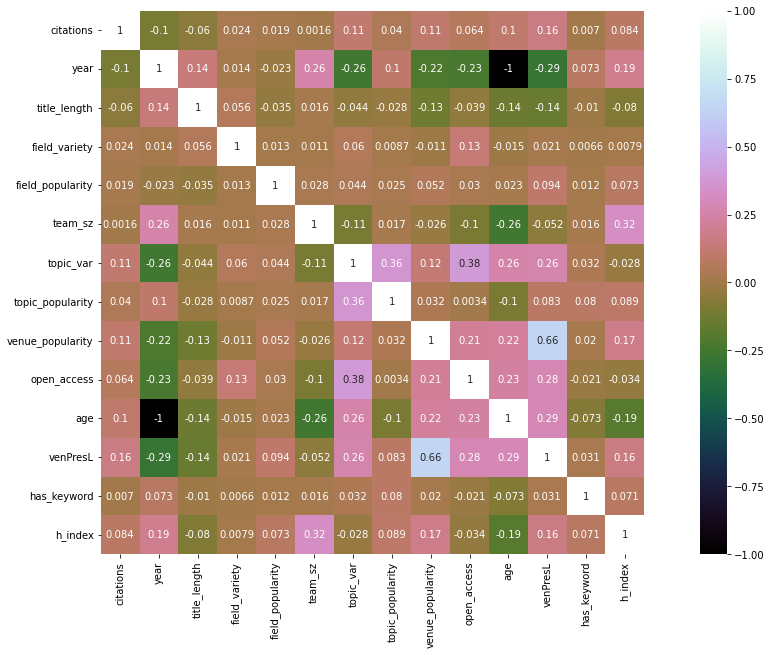

In [2]:
"""
Look at some correlations - full num_X
"""
# names: X_train, X_val, y_train, y_val

# From: https://www.kaggle.com/ankitjha/comparing-regression-models
import seaborn as sns
corr_mat = num_X.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')


<AxesSubplot:>

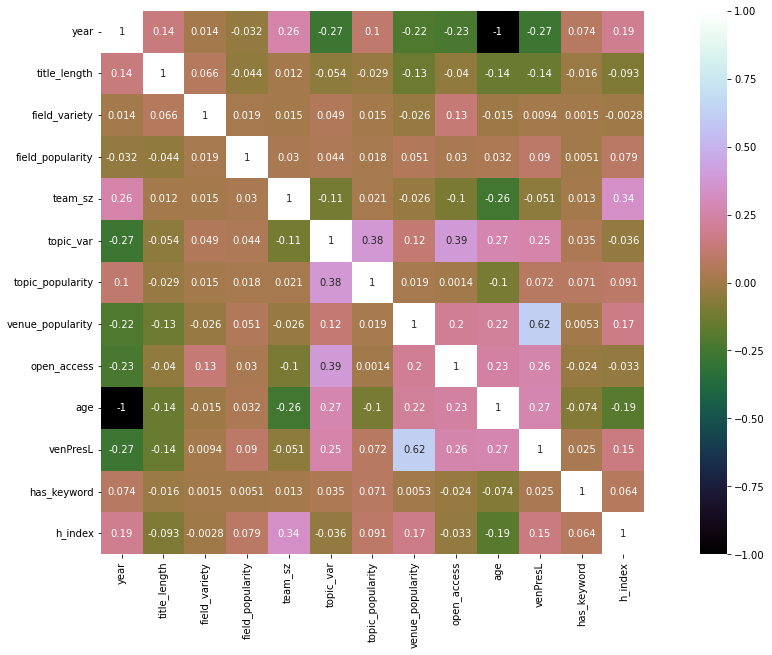

In [3]:
"""
Look at some correlations - X_train
"""
# names: X_train, X_val, y_train, y_val

#temp = y_train hstack X_train


# From: https://www.kaggle.com/ankitjha/comparing-regression-models
corr_mat = X_train.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

In [ ]:
#names: X_train, X_val, y_train, y_val

# Basic regression model Using any continuous variables
#     Establish data
#     Define model: regression model: sklearn.linear_model.LinearRegression
#     Fit model
#     Predict
#     Evaluate


# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val  = scaler.transform(X_val)



from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier  # from ML w4[35]



# 1. z-score
reg = model.fit(X = X_train, y = y_train)  # 2. fit model
print("Model weights:", reg.coef_)
print("Model intercept/bias:", reg.intercept_)
y_pred_val = model.predict(X_val)  # 3. predict
a = r2_score(y_val, y_pred_val)  # 4. evaluate
b = mean_absolute_error(y_val, y_pred_val)


In [ ]:
for index, i_paper in data.iterrows():
    fields = i_paper['fields_of_study'] 
    if fields == None:   
        fields = ""  
        i_papers['fields_of_study'] = i_paper['fields_of_study'].replace([None, ""])
data.head()

In [4]:
# Create a mini version of the main 'data' dataframe

import pandas as pd
import numpy as np
# %pwd
# %cd C:\Users\r_noc\Desktop\Python\GIT\machinelearning
    
play = data.sample(100, replace = False, axis = 0, random_state = 123)  


print(play.shape)
# print(play['abstract'])

print(list(play.columns))
# play['has_keyword'] = np.nan
# print(play.shape)
# play

(100, 11)
['doi', 'title', 'abstract', 'authors', 'venue', 'year', 'references', 'topics', 'is_open_access', 'fields_of_study', 'citations']


In [132]:
##KEEP!!!

# pull the top n most cited papers from y_train
# print(type(y_train))
# df[df['Revenue'] >= df.groupby('Cluster')['Revenue'].transform('quantile', 0.98)]
# Series.quantile(q=0.5, interpolation='linear')



# source: https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c
import yake

def best_keywords (data, words_per_paper):
    a = data['citations'].quantile(q = .9)
    best = data[data['citations'] > a]
    best['keywords'] = ''

    extractor = yake.KeywordExtractor()
    language = 'en'
    max_ngram = 1
    deduplication_threshold = 0.1   # low value = duplication of keywords in ngrams not allowed
    num_keywords = words_per_paper


    for index, i_paper in best.iterrows(): # iterate over the dataframe 
        text = i_paper['abstract']
        custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram, dedupLim=deduplication_threshold, 
                                                    top=num_keywords, features=None)
        keywords = custom_kw_extractor.extract_keywords(text)

        k = []
        for i in keywords:
            k.append(i[0].lower())

        best.at[index, 'keywords'] = k

    a = best['keywords'].tolist()
    a = [x for l in a for x in l]
    
    return a


print(best_keywords(play, 3))

# T/F if keywords are present in the/any article 



C:\Users\r_noc\AppData\Local\Temp/ipykernel_11700/1268034361.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best['keywords'] = ''


['methods', 'unsupervised', 'broadly', 'bleu', 'discriminative', 'tasks', 'sentiment', 'polarities', 'individual', 'classifiers', 'recent', 'show', 'coreference', 'resolution', 'language', 'original', 'summary', 'text', 'relationships', 'system', 'noun', 'processing', 'language', 'ubiquitous', 'chinese', 'word', 'extraction', 'mplus', 'text', 'paper']


In [146]:
# source: https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c
import yake



print(best_keywords(play, 3, .95)) # from [data set] get [integer] keywords from papers in the top [citation rate]


{'extraction', 'language', 'word', 'chinese', 'processing', 'bleu', 'ubiquitous', 'classifiers', 'tasks', 'discriminative', 'polarities', 'individual', 'recent', 'show', 'sentiment'}


C:\Users\r_noc\AppData\Local\Temp/ipykernel_11700/2802250267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best['keywords'] = ''


In [68]:
keywords

[('MPLUS', 0.060178492117561516),
 ('Networks', 0.060178492117561516),
 ('Bayesian', 0.07375243851453402),
 ('BNs', 0.07782964431366018),
 ('medical', 0.11984051217342846)]

In [ ]:
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z  =scaler.transform(X_val)

lr = [ 10 ** x for x in range(-6,1)]

settings = []

for learning_rate in ['constant', 'optimal', 'invscaling']:
    for loss in ['squared_loss', 'huber']:
        for eta0 in lr:
            model = SGDRegressor(learning_rate=learning_rate, eta0=eta0, loss=loss,random_state=666, max_iter=5000)
            model.fit(X_train_z, y_train)
            mae = mean_absolute_error(y_val, model.predict(X_val_z))
            r2 =  r2_score(y_val, model.predict(X_val_z))
            settings.append((learning_rate, eta0, loss, mae, r2))
            print(settings[-1])


In [ ]:
fup_x = X_train
fdown_x = X_val


fup_x = fup_x['year']
fdown_x = fdown_x['year']

print(type(fup_x))    ##why is this a series?????

In [ ]:
print(list(X_train.columns))
print(list(X_train.columns) == list(X_val.columns))
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)
print()
print(fup_x.shape, fdown_x.shape)

In [ ]:
#names: X_train, X_val, y_train, y_val

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

scaler = StandardScaler()
X_train_z = scaler.fit_transform(fup_x)
X_val_z  =scaler.transform(fdown_x)


# lr = [1, .1, .01, .001]

# settings = []

# for learning_rate in ['constant', 'optimal', 'invscaling']:
#     for loss in ['squared_loss', 'huber']:
#         for eta0 in lr:

model = SGDRegressor(learning_rate=learning_rate, eta0=eta0, loss=loss,random_state=666, max_iter=1000)
model.fit(X_train_z, y_train)
mae = mean_absolute_error(y_val, model.predict(X_val_z))
r2 =  r2_score(y_val, model.predict(X_val_z))


# settings.append((learning_rate, eta0, loss, mae, r2))
# print(settings[-1])

print(mae, r2)

In [ ]:
X_train_z